### View images

In [1]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

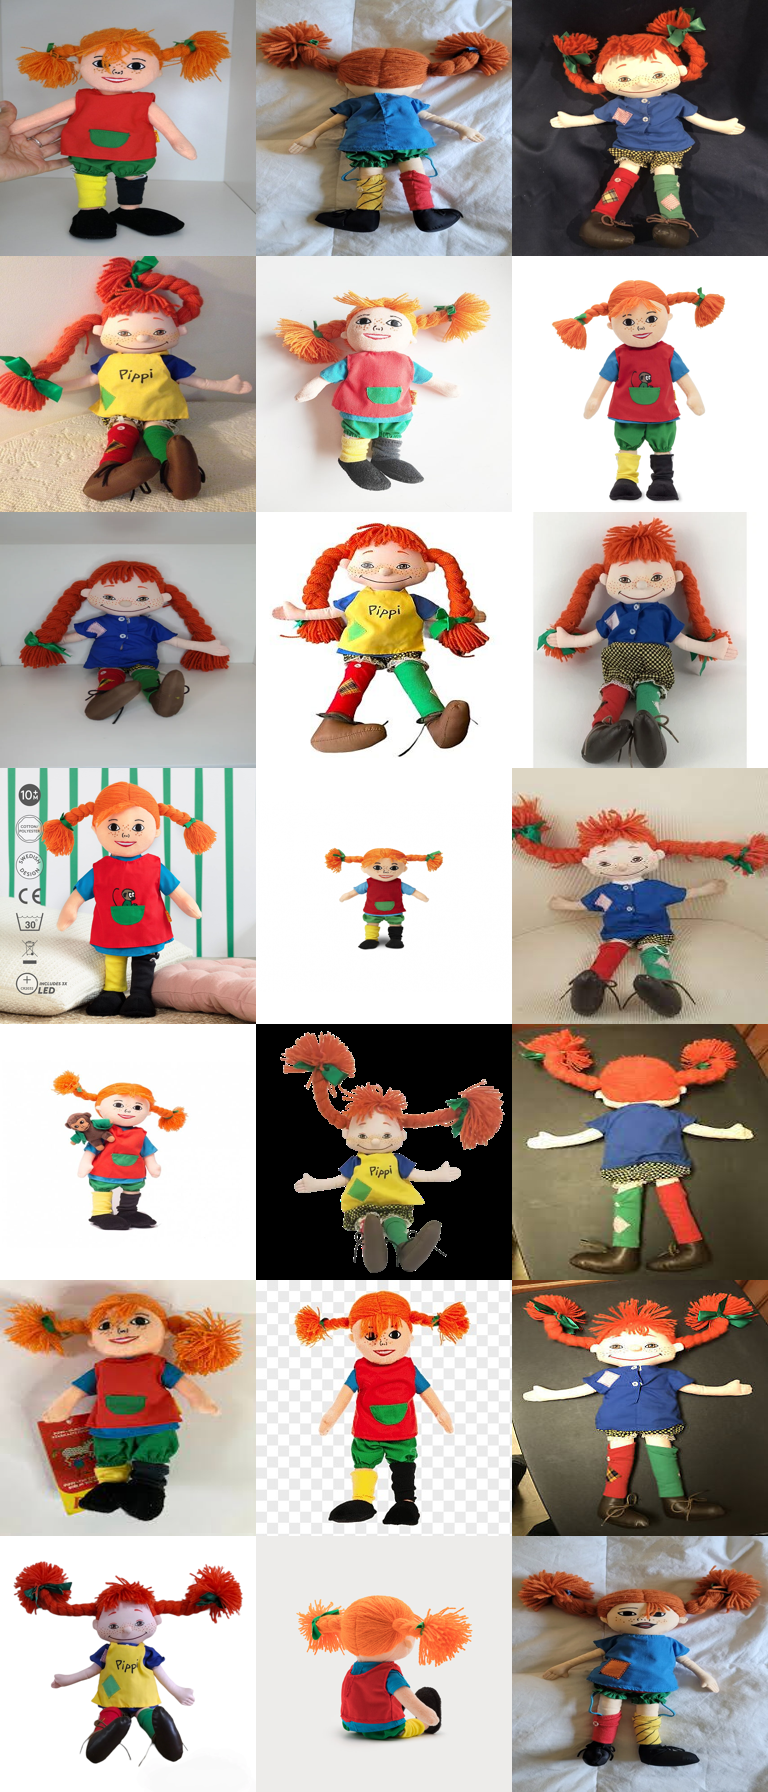

In [7]:
import glob

# change path to display images from your local dir
img_paths = "./pippiAB/*.jpeg"
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = len(imgs)

cols = 3
rows = num_imgs_to_preview // cols 
rest = num_imgs_to_preview % cols
if rest: rows +=1

image_grid(imgs[:num_imgs_to_preview], rows, cols)

### Generate custom captions with BLIP

In [3]:
import requests
from transformers import AutoProcessor, BlipForConditionalGeneration
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# load the processor and the captioning model
blip_processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base",torch_dtype=torch.float16).to(device)

# captioning utility
def caption_images(input_image):
    inputs = blip_processor(images=input_image, return_tensors="pt").to(device, torch.float16)
    pixel_values = inputs.pixel_values

    generated_ids = blip_model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_caption

/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# create a list of (Pil.Image, path) pairs
local_dir = "./pippiAB/"
imgs_and_paths = [(path,Image.open(path)) for path in glob.glob(f"{local_dir}*.jpeg")]
len(imgs_and_paths)

21

In [6]:
import json

caption_prefix = "PippiXL, " #@param
with open(f'{local_dir}metadata.jsonl', 'w') as outfile:
  for img in imgs_and_paths:
      caption = caption_prefix + caption_images(img[1]).split("\n")[0]
      entry = {"file_name":img[0].split("/")[-1], "prompt": caption}
      json.dump(entry, outfile)
      outfile.write('\n')

/opt/miniconda3/lib/python3.12/site-packages/transformers/utils/import_utils.py:670: FutureWarning: `torch._dynamo.external_utils.is_compiling` is deprecated. Use `torch.compiler.is_compiling` instead.
  return dynamo.is_compiling()


Open the generated file **metadata.json** and modify the prompts as desired.